In [42]:
#!pip install --upgrade ultralytics
#!pip install --upgrade -U ray[tune]

In [43]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import torch
import random
import yaml

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# import IPython.display as display
from PIL import Image
import cv2
from tabulate import tabulate

from ultralytics import YOLO

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
#!mkdir -p /content/Indoor_Objects_Detection/
#!cp -v /content/drive/MyDrive/Dataset/Indoor_Objects_Detection/archive.zip /content/Indoor_Objects_Detection/
#!unzip -o /content/drive/MyDrive/Dataset/Indoor_Objects_Detection/archive.zip -d /content/Indoor_Objects_Detection/

In [45]:
# Setting up the device for training (Apple GPU or CPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Running on", device)

Running on cuda


In [46]:
class CFG:
    DEBUG = False # Set to True to make quick experiments
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 42

    # classes
    CLASSES = ['door', 'cabinetDoor','refrigeratorDoor', 'window', 'chair', 'table','cabinet', 'couch', 'openedDoor', 'pole']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 100 # 100
    BATCH_SIZE = 16

    BASE_MODEL = 'yolov8x' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

    OPTIMIZER = 'AdamW' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-4
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.3
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.1
    AUGMENT = True

    # paths
    CUSTOM_DATASET_DIR = '/content/Indoor_Objects_Detection/'
    OUTPUT_DIR = '/content/'

In [47]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [48]:
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- door
- cabinetDoor
- refrigeratorDoor
- window
- chair
- table
- cabinet
- couch
- openedDoor
- pole
nc: 10
test: /content/Indoor_Objects_Detection/test
train: /content/Indoor_Objects_Detection/train
val: /content/Indoor_Objects_Detection/valid



In [49]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (1024, 683, 3) 



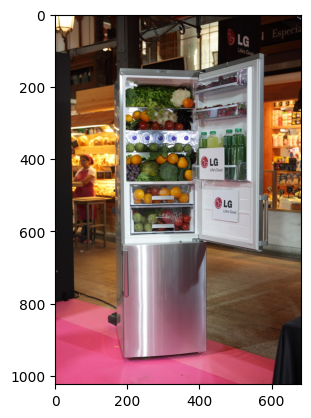

In [50]:
example_image_path = CFG.CUSTOM_DATASET_DIR + 'train/images/b15de360b5a290e0.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

**Display several images**

In [51]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


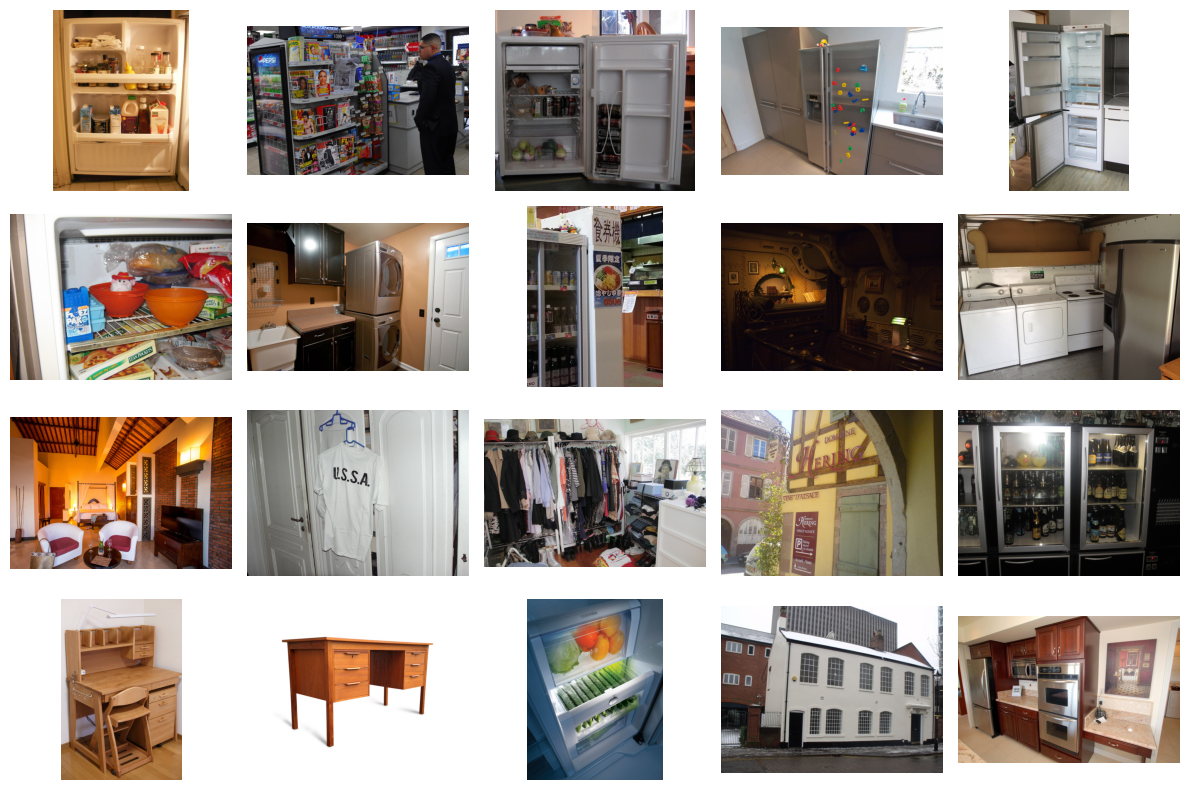

In [52]:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)

**Store image properties**

In [53]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [54]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 683, 'height': 1024, 'channels': 3, 'dtype': dtype('uint8')}

**Basic statistics**

In [55]:
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
with pd.option_context('display.max_columns', None):
    display(dataset_stats_df)

,Mode,door,cabinetDoor,refrigeratorDoor,window,chair,table,cabinet,couch,openedDoor,pole,Data_Volume
0,train,309,448,332,187,105,165,138,22,68,14,1008
1,valid,63,99,85,39,24,30,28,1,13,4,230
2,test,25,42,1,49,38,41,44,31,18,3,104


**Visualize Class distribution**

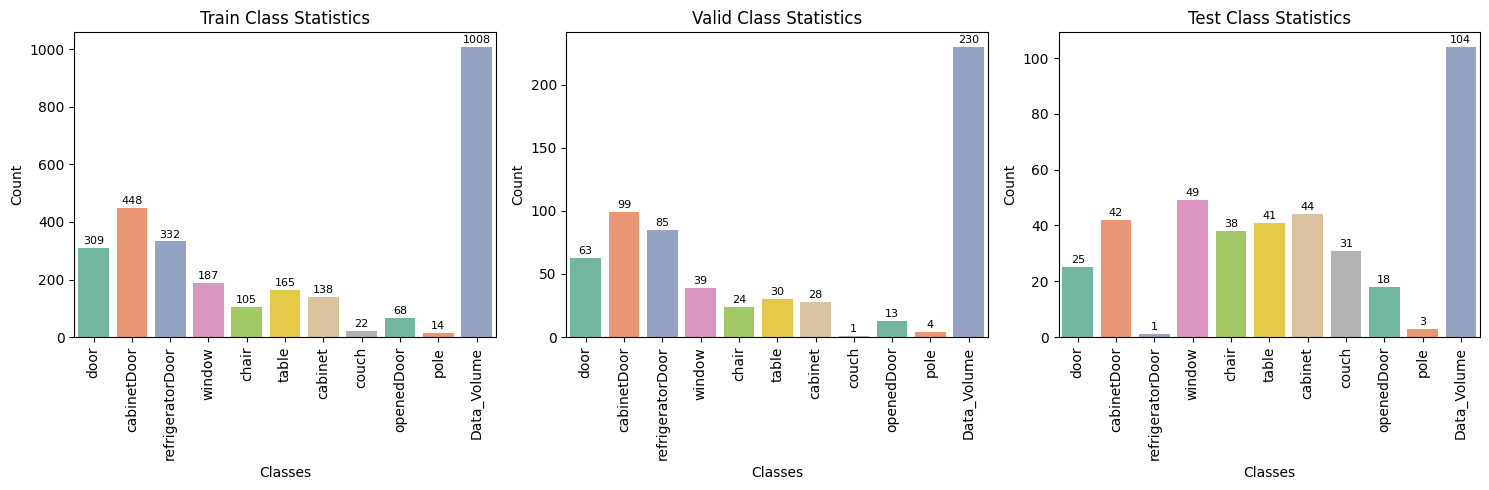

In [56]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    subset = dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode')
    subset = subset.melt(var_name='Classes', value_name='Count')  # Перетворення на довгий формат

    sns.barplot(
        data=subset,
        x='Classes',
        y='Count',
        ax=axes[i],
        palette='Set2'
    )

    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

**Test the model on a selected image, and observe that the pre-trained model correctly identifies the person class**

In [57]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

model.info()

results = model.predict(
    source = example_image_path,
    classes = [0],
    conf = 0.30,
    device = device, # inference with CPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

YOLOv8x summary: 365 layers, 68,229,648 parameters, 0 gradients, 258.5 GFLOPs

WARNING ⚠️ imgsz=[1024, 683] must be multiple of max stride 32, updating to [1024, 704]
image 1/1 /content/Indoor_Objects_Detection/train/images/b15de360b5a290e0.jpg: 1024x704 1 person, 14.6ms
Speed: 2.9ms preprocess, 14.6ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 704)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (1024, 683, 3) 



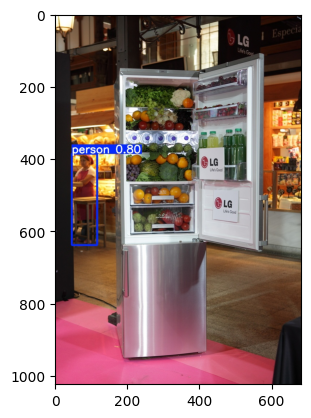

In [58]:
### check predictions with base model
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'runs/detect/predict/{example_image_inference_output}')

In [59]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov8x.pt
Epochs:  100
Batch:  16


**Model training**

In [60]:
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,
    augment=CFG.AUGMENT,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,

    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    device = device,
    verbose = False,
)

engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/data.yaml, epochs=100, time=None, patience=20, batch=16, imgsz=(1024, 683), save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=yolov8x_ppe_css_100_epochs, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.3, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, opt

train: Scanning /content/Indoor_Objects_Detection/train/labels.cache... 1008 images, 120 backgrounds, 0 corrupt: 100%|██████████| 1012/1012 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Indoor_Objects_Detection/valid/labels.cache... 230 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8x_ppe_css_100_epochs/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 103 weight(decay=0.0), 110 weight(decay=0.0005), 109 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to runs/detect/yolov8x_ppe_css_100_epochs
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      37.6G      2.007      3.359      2.003         34       1024: 100%|██████████| 64/64 [00:31<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.01it/s]

                   all        230       1289      0.141      0.064     0.0904      0.066



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      31.5G      1.578      2.356      1.668         56       1024: 100%|██████████| 64/64 [00:30<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.36it/s]

                   all        230       1289     0.0354      0.398       0.12     0.0701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      31.7G      1.541      2.135      1.638         16       1024: 100%|██████████| 64/64 [00:30<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.29it/s]

                   all        230       1289      0.497      0.212      0.206      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      31.8G      1.448      1.925      1.573         57       1024: 100%|██████████| 64/64 [00:30<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]

                   all        230       1289      0.618      0.251      0.233       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      31.8G      1.416       1.78      1.518         29       1024: 100%|██████████| 64/64 [00:29<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

                   all        230       1289      0.589       0.29      0.258      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      31.7G      1.373      1.622      1.474         24       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

                   all        230       1289      0.611      0.314      0.288      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      31.8G      1.355      1.557       1.47         34       1024: 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.25it/s]

                   all        230       1289      0.695      0.288      0.319       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      31.6G       1.33      1.454      1.448         31       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.21it/s]

                   all        230       1289      0.587      0.319      0.338      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      31.7G      1.299      1.414      1.425         48       1024: 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.28it/s]

                   all        230       1289      0.549       0.36       0.35      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      31.7G      1.272      1.385      1.411         48       1024: 100%|██████████| 64/64 [00:30<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]

                   all        230       1289      0.421      0.372      0.331      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      31.7G      1.277       1.33      1.416         20       1024: 100%|██████████| 64/64 [00:29<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.25it/s]

                   all        230       1289      0.553       0.36      0.358      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      31.7G      1.262      1.266      1.377         53       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.28it/s]

                   all        230       1289      0.566      0.361      0.355      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      31.7G      1.238      1.249      1.376         28       1024: 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.27it/s]

                   all        230       1289      0.684      0.346      0.355      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      31.7G      1.231      1.219      1.379         32       1024: 100%|██████████| 64/64 [00:30<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

                   all        230       1289      0.461      0.388      0.366      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      31.8G      1.191      1.141      1.345         46       1024: 100%|██████████| 64/64 [00:29<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.27it/s]

                   all        230       1289      0.574      0.349      0.365      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      31.7G      1.184      1.114      1.341         17       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.26it/s]

                   all        230       1289      0.443      0.391      0.378      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      31.7G      1.155      1.065      1.313         15       1024: 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.28it/s]

                   all        230       1289       0.49      0.387      0.379      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      31.7G      1.135      1.048      1.307         70       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

                   all        230       1289       0.49      0.356      0.382      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      31.8G      1.132      1.015      1.301         48       1024: 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

                   all        230       1289       0.45      0.514      0.384      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      31.7G      1.105     0.9861      1.277         40       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.28it/s]

                   all        230       1289      0.491      0.368      0.389      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      31.7G       1.14      1.007      1.292         58       1024: 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

                   all        230       1289      0.371      0.438      0.396      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      31.8G      1.119     0.9657      1.281         62       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.29it/s]

                   all        230       1289      0.394      0.533      0.399      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      31.7G      1.087     0.9514      1.272         37       1024: 100%|██████████| 64/64 [00:29<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.28it/s]

                   all        230       1289      0.518      0.337       0.38      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      31.7G      1.081     0.9177      1.251         23       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.26it/s]

                   all        230       1289      0.471      0.387      0.382      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      31.7G      1.065      0.903       1.25         35       1024: 100%|██████████| 64/64 [00:29<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.28it/s]

                   all        230       1289      0.521      0.364      0.394      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      31.7G      1.049     0.8675      1.237         40       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.27it/s]

                   all        230       1289      0.381        0.4      0.384      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      31.6G      1.053     0.8723      1.241         51       1024: 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.32it/s]

                   all        230       1289      0.369      0.533      0.392      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      31.7G      1.026     0.8616      1.223         49       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.34it/s]

                   all        230       1289       0.44      0.487      0.436       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      31.7G      1.039     0.8381      1.225         23       1024: 100%|██████████| 64/64 [00:29<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.31it/s]

                   all        230       1289       0.49      0.491      0.437       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      31.8G     0.9876     0.8198      1.203         60       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.32it/s]

                   all        230       1289      0.394      0.424      0.382      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      31.7G     0.9982     0.8094      1.202         42       1024: 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.31it/s]

                   all        230       1289      0.497      0.444      0.431      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      31.7G     0.9757     0.7897      1.202         10       1024: 100%|██████████| 64/64 [00:30<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.35it/s]

                   all        230       1289       0.51      0.457      0.419      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      32.1G     0.9888     0.7991      1.192         84       1024: 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.34it/s]

                   all        230       1289      0.432      0.415      0.407      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      31.7G     0.9737     0.7634      1.189         53       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.34it/s]

                   all        230       1289      0.526      0.366      0.401      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      31.7G     0.9565     0.7474      1.181         40       1024: 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

                   all        230       1289      0.566      0.384      0.404      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      31.7G     0.9423     0.7364      1.163         30       1024: 100%|██████████| 64/64 [00:30<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.32it/s]

                   all        230       1289      0.481      0.476      0.423      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      31.7G     0.9293     0.7296      1.164         21       1024: 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.31it/s]

                   all        230       1289      0.387      0.504      0.411      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      31.7G     0.9305      0.729      1.154         19       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.34it/s]

                   all        230       1289      0.439      0.483      0.432      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      31.8G     0.9283      0.722      1.162         87       1024: 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.34it/s]

                   all        230       1289       0.43      0.391      0.402      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      31.7G     0.9219     0.7271      1.148         41       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

                   all        230       1289      0.502       0.45      0.425      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      31.8G     0.9187     0.6948      1.151         24       1024: 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.33it/s]

                   all        230       1289      0.521      0.454      0.444      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      31.7G     0.8865     0.6845      1.126         28       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.31it/s]

                   all        230       1289      0.435      0.499      0.433      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      31.6G     0.9005     0.6786      1.141         24       1024: 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.26it/s]

                   all        230       1289      0.344      0.471      0.413      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      31.7G     0.8922     0.6611       1.13         38       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.28it/s]

                   all        230       1289      0.565      0.367      0.403      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      31.8G     0.8672     0.6524      1.117         47       1024: 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]

                   all        230       1289      0.465      0.477      0.439      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      31.6G     0.8732     0.6564      1.131         34       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.34it/s]

                   all        230       1289      0.449      0.502      0.446      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      31.8G     0.8821     0.6676      1.124         23       1024: 100%|██████████| 64/64 [00:29<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]

                   all        230       1289      0.443      0.356      0.393      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      31.8G     0.8502      0.636      1.102         66       1024: 100%|██████████| 64/64 [00:30<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.29it/s]

                   all        230       1289      0.463      0.441      0.437      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      31.7G     0.8508     0.6327      1.108         38       1024: 100%|██████████| 64/64 [00:29<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.33it/s]

                   all        230       1289      0.427       0.47      0.444       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      31.7G      0.854     0.6354      1.104        138       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.32it/s]

                   all        230       1289      0.438      0.355      0.406      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      31.7G     0.8358     0.6145      1.099         28       1024: 100%|██████████| 64/64 [00:29<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

                   all        230       1289       0.43      0.485      0.426      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      31.7G     0.8313     0.6088      1.097         17       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.31it/s]

                   all        230       1289      0.573      0.443      0.435      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      31.7G     0.8231     0.6192      1.093         37       1024: 100%|██████████| 64/64 [00:29<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.32it/s]

                   all        230       1289      0.393      0.528      0.422      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      31.7G     0.8231     0.6001      1.086         51       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.32it/s]

                   all        230       1289      0.393      0.403       0.41      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      31.7G     0.8172     0.6152       1.08         22       1024: 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.32it/s]

                   all        230       1289      0.395      0.388      0.386      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      31.8G     0.8147     0.6011      1.081         31       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.28it/s]

                   all        230       1289      0.384      0.388        0.4      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      31.8G     0.8005     0.5873      1.079         38       1024: 100%|██████████| 64/64 [00:29<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

                   all        230       1289      0.421      0.392      0.407      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      31.7G     0.7907     0.5838      1.071         13       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

                   all        230       1289      0.404      0.462      0.407      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      31.8G     0.8049     0.5938      1.079         67       1024: 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.33it/s]

                   all        230       1289       0.45       0.38      0.409      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      31.7G     0.7966     0.5906      1.079         52       1024: 100%|██████████| 64/64 [00:30<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.35it/s]

                   all        230       1289      0.403      0.413      0.397      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      31.7G     0.7767     0.5869      1.071         37       1024: 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.34it/s]

                   all        230       1289      0.407      0.552      0.413      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      31.8G     0.7795     0.5837      1.068         50       1024: 100%|██████████| 64/64 [00:30<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

                   all        230       1289      0.367      0.551      0.415       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      31.6G     0.7675     0.5614      1.051         55       1024: 100%|██████████| 64/64 [00:29<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.33it/s]

                   all        230       1289      0.402      0.418      0.402       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      31.7G     0.7809     0.5555      1.063         41       1024: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

                   all        230       1289      0.575      0.424      0.425      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      31.7G     0.7619     0.5532      1.051         24       1024: 100%|██████████| 64/64 [00:29<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.32it/s]

                   all        230       1289      0.382      0.426      0.411      0.244
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 45, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



65 epochs completed in 0.629 hours.
Optimizer stripped from runs/detect/yolov8x_ppe_css_100_epochs/weights/last.pt, 123.7MB
Optimizer stripped from runs/detect/yolov8x_ppe_css_100_epochs/weights/best.pt, 123.7MB

Validating runs/detect/yolov8x_ppe_css_100_epochs/weights/best.pt...
Ultralytics 8.3.13 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 286 layers, 61,605,198 parameters, 0 gradients, 226.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


                   all        230       1289      0.585      0.463      0.531      0.342
Speed: 0.3ms preprocess, 20.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/yolov8x_ppe_css_100_epochs


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c48ce7e63b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [61]:
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = True,
    nms = False,
)

Ultralytics 8.3.13 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
WARNING ⚠️ imgsz=[1024, 683] must be multiple of max stride 32, updating to [1024, 704]
Model summary (fused): 286 layers, 61,605,198 parameters, 0 gradients, 226.7 GFLOPs

PyTorch: starting from 'runs/detect/yolov8x_ppe_css_100_epochs/weights/best.pt' with input shape (1, 3, 1024, 704) BCHW and output shape(s) (1, 14, 14784) (118.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim==0.1.34', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.3/140.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 309.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.2/226.2 MB 198.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 165.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 259.3 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 13.3s, insta

'runs/detect/yolov8x_ppe_css_100_epochs/weights/best.onnx'

In [62]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['/content/runs/detect/yolov8x_ppe_css_100_epochs/F1_curve.png',
 '/content/runs/detect/yolov8x_ppe_css_100_epochs/R_curve.png',
 '/content/runs/detect/yolov8x_ppe_css_100_epochs/confusion_matrix.png',
 '/content/runs/detect/yolov8x_ppe_css_100_epochs/PR_curve.png',
 '/content/runs/detect/yolov8x_ppe_css_100_epochs/P_curve.png',
 '/content/runs/detect/yolov8x_ppe_css_100_epochs/results.png',
 '/content/runs/detect/yolov8x_ppe_css_100_epochs/confusion_matrix_normalized.png',
 '/content/runs/detect/yolov8x_ppe_css_100_epochs/labels.jpg',
 '/content/runs/detect/yolov8x_ppe_css_100_epochs/labels_correlogram.jpg']

/content/runs/detect/yolov8x_ppe_css_100_epochs/F1_curve.png


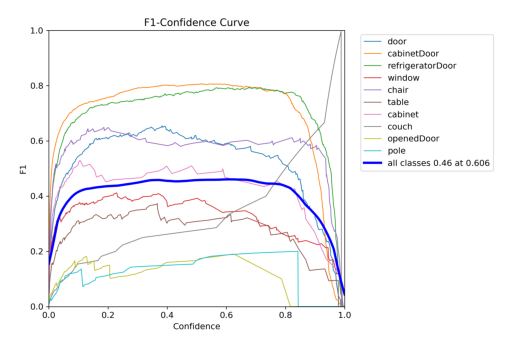



/content/runs/detect/yolov8x_ppe_css_100_epochs/PR_curve.png


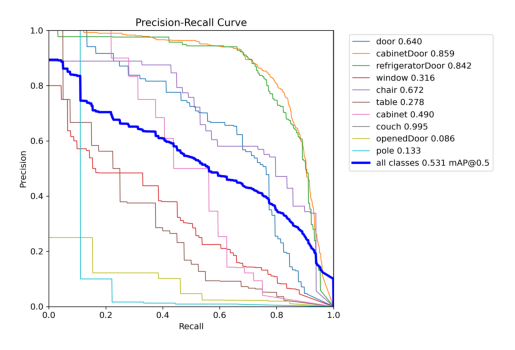



/content/runs/detect/yolov8x_ppe_css_100_epochs/P_curve.png


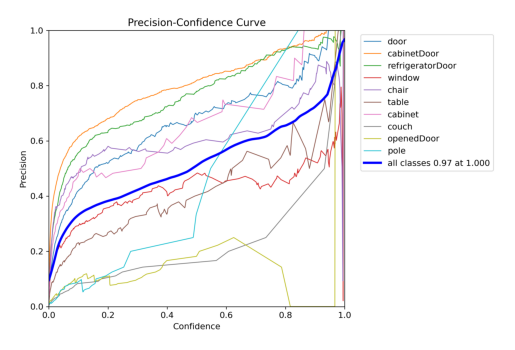



/content/runs/detect/yolov8x_ppe_css_100_epochs/R_curve.png


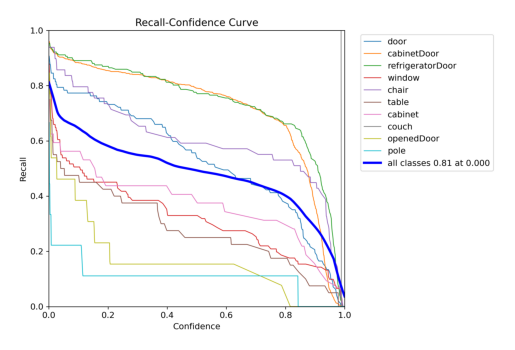



/content/runs/detect/yolov8x_ppe_css_100_epochs/confusion_matrix.png


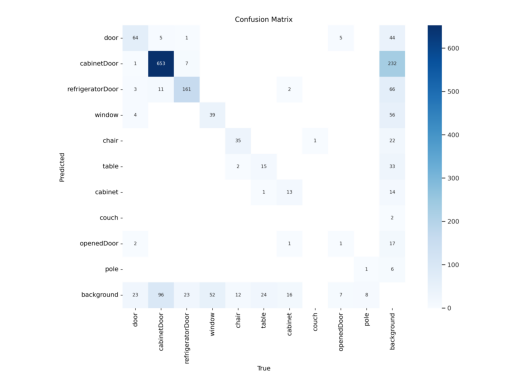



/content/runs/detect/yolov8x_ppe_css_100_epochs/confusion_matrix_normalized.png


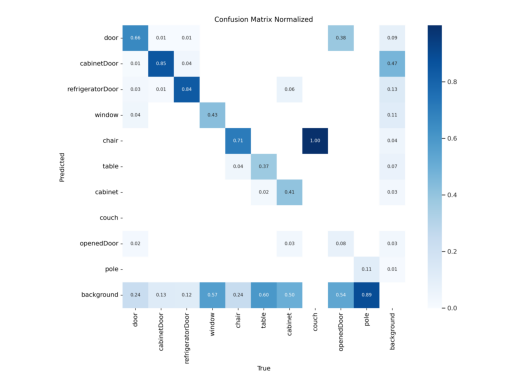



/content/runs/detect/yolov8x_ppe_css_100_epochs/labels.jpg


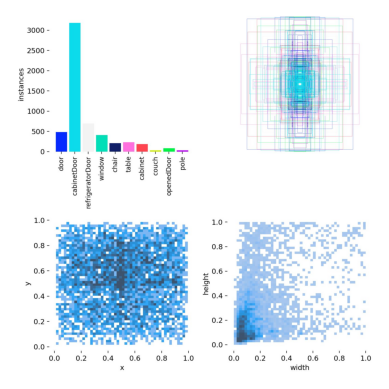



/content/runs/detect/yolov8x_ppe_css_100_epochs/labels_correlogram.jpg


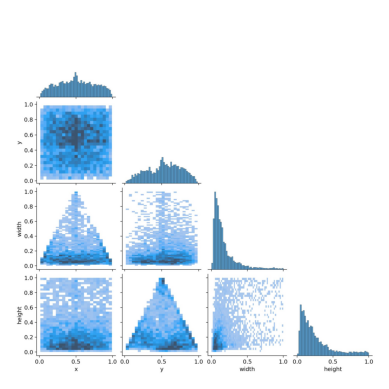



/content/runs/detect/yolov8x_ppe_css_100_epochs/results.png


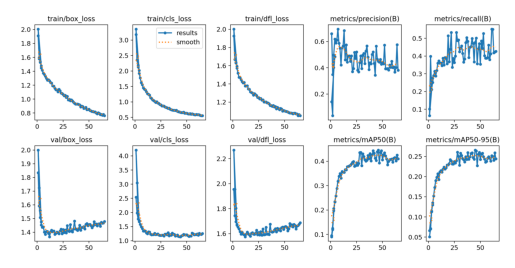

In [63]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')


In [64]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,49.8154,1.91110,3.18043,1.92797,0.65922,0.10176,0.09526,0.05087,1.83487,2.54080,1.95477,0.066897,0.000033,0.000033
1,2,90.5489,1.59561,2.36436,1.66860,0.34834,0.20232,0.12480,0.07105,1.59261,1.97956,1.74466,0.033596,0.000066,0.000066
2,3,131.2970,1.52760,2.18917,1.63037,0.40184,0.24650,0.19704,0.11283,1.50743,1.77033,1.69545,0.000295,0.000098,0.000098
3,4,171.9790,1.47884,2.01807,1.59333,0.48503,0.27647,0.23487,0.13486,1.47490,1.67492,1.66764,0.000097,0.000097,0.000097
4,1,41.3521,2.00675,3.35908,2.00320,0.14146,0.06403,0.09042,0.06595,1.99945,4.20498,2.26814,0.067220,0.000033,0.000033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,61,2124.5800,0.77669,0.58693,1.07094,0.40721,0.55219,0.41314,0.25177,1.44308,1.19940,1.63800,0.000041,0.000041,0.000041
65,62,2158.9200,0.77949,0.58372,1.06822,0.36721,0.55096,0.41518,0.24961,1.47215,1.26491,1.66077,0.000040,0.000040,0.000040
66,63,2193.4900,0.76755,0.56136,1.05065,0.40197,0.41845,0.40174,0.24043,1.46714,1.23593,1.66632,0.000039,0.000039,0.000039
67,64,2227.9900,0.78091,0.55549,1.06294,0.57534,0.42353,0.42528,0.25883,1.46836,1.22651,1.67523,0.000038,0.000038,0.000038


In [65]:
data = [
    ['Training Box Loss', f"{df['train/box_loss'].min():.5f}", df['train/box_loss'].argmin() + 1],
    ['Validation Box Loss', f"{df['val/box_loss'].min():.5f}", df['val/box_loss'].argmin() + 1],
    ['Training Cls Loss', f"{df['train/cls_loss'].min():.5f}", df['train/cls_loss'].argmin() + 1],
    ['Validation Cls Loss', f"{df['val/cls_loss'].min():.5f}", df['val/cls_loss'].argmin() + 1],
    ['Training DFL Loss', f"{df['train/dfl_loss'].min():.5f}", df['train/dfl_loss'].argmin() + 1],
    ['Validation DFL Loss', f"{df['val/dfl_loss'].min():.5f}", df['val/dfl_loss'].argmin() + 1]
]

headers = ["Metric", "Loss", "Epoch"]

print(tabulate(data, headers=headers, tablefmt="grid"))

+---------------------+---------+---------+
| Metric              |    Loss |   Epoch |
+=====================+=========+=========+
| Training Box Loss   | 0.7619  |      69 |
+---------------------+---------+---------+
| Validation Box Loss | 1.36709 |      16 |
+---------------------+---------+---------+
| Training Cls Loss   | 0.55318 |      69 |
+---------------------+---------+---------+
| Validation Cls Loss | 1.14104 |      48 |
+---------------------+---------+---------+
| Training DFL Loss   | 1.05065 |      67 |
+---------------------+---------+---------+
| Validation DFL Loss | 1.57531 |      16 |
+---------------------+---------+---------+


**Training and Validation Loss Metrics Visualization**

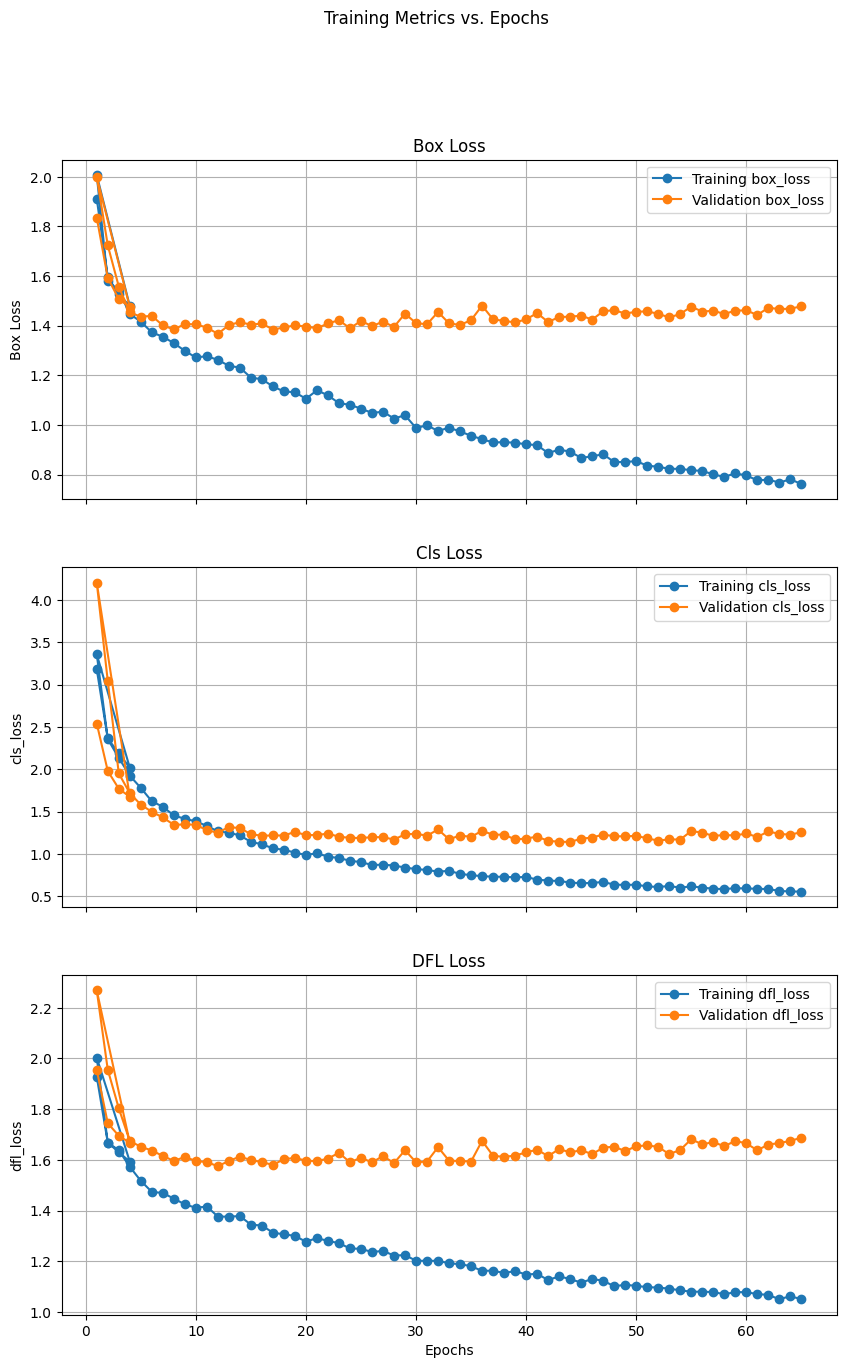

In [66]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()


**Validation results**

In [67]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [68]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

/content/runs/detect/yolov8x_ppe_css_100_epochs/val_batch0_pred.jpg


/content/runs/detect/yolov8x_ppe_css_100_epochs/val_batch0_pred.jpg


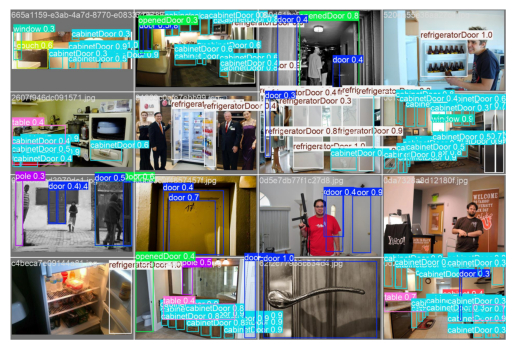

In [69]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)

**Model Validation and Class-wise Performance Metrics Analysis**

In [70]:
# Model validation.
results = model.val(
    data=os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),
    device=device,
    verbose=True
)


Model summary (fused): 286 layers, 61,605,198 parameters, 0 gradients, 226.7 GFLOPs


val: Scanning /content/Indoor_Objects_Detection/valid/labels.cache... 230 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


                   all        230       1289      0.571      0.469      0.529      0.342
                  door         63         97      0.724      0.495      0.635      0.384
           cabinetDoor         99        765       0.86      0.754      0.862      0.491
      refrigeratorDoor         85        192      0.825       0.75      0.839      0.559
                window         39         91      0.451      0.264      0.319      0.189
                 chair         24         49      0.612      0.571      0.666      0.395
                 table         30         40       0.45      0.225      0.267       0.13
               cabinet         28         32      0.745      0.366      0.481      0.347
                 couch          1          1      0.206          1      0.995      0.796
            openedDoor         13         13      0.247      0.154     0.0937     0.0384
                  pole          4          9      0.592      0.111      0.133     0.0895
Speed: 0.3ms preproce

In [71]:
# Number of classes.
nc = results.box.nc

# Get precision, recall and F1-score for each class.
class_precision = results.box.p  # Accuracy for each class.
class_recall = results.box.r     # Completeness for each class.
class_f1_score = results.box.f1  # F1-score for each class.

# Getting AP for each class at IoU 0.5 and 0.5-0.95.
class_ap50 = results.box.ap50  # AP for each class at IoU 0.5
class_ap = results.box.ap      # AP for each class at IoU 0.5:0.95

# Create a table to display metrics for each class
performance_data = {
    'Class': CFG.CLASSES,
    'Precision': class_precision,
    'Recall': class_recall,
    'F1-Score': class_f1_score,
    'AP@0.5': class_ap50,
    'AP@0.5:0.95': class_ap
}

performance_df = pd.DataFrame(performance_data)

# Print results for skin class
print("\nClass-wise Performance Metrics:")
print(performance_df)

# Determining the best and worst classes by F1 score
best_class = performance_df.iloc[performance_df['F1-Score'].idxmax()]['Class']
worst_class = performance_df.iloc[performance_df['F1-Score'].idxmin()]['Class']

print(f"\nBest performing class: {best_class}")
print(f"Worst performing class: {worst_class}")


Class-wise Performance Metrics:
              Class  Precision    Recall  F1-Score    AP@0.5  AP@0.5:0.95
0              door   0.724016  0.494845  0.587886  0.635024     0.384011
1       cabinetDoor   0.859861  0.753936  0.803422  0.861934     0.490503
2  refrigeratorDoor   0.825023  0.750000  0.785725  0.838882     0.559065
3            window   0.451206  0.263736  0.332892  0.318669     0.189472
4             chair   0.611600  0.571429  0.590832  0.665901     0.394552
5             table   0.450402  0.225000  0.300089  0.266860     0.130179
6           cabinet   0.745383  0.366343  0.491247  0.480882     0.347030
7             couch   0.206171  1.000000  0.341861  0.995000     0.796000
8        openedDoor   0.246806  0.153846  0.189542  0.093740     0.038422
9              pole   0.592154  0.111111  0.187113  0.132847     0.089510

Best performing class: cabinetDoor
Worst performing class: pole


**1. Детальний аналіз отриманих результатів**

*Пояснення, чому модель могла не досягти очікуваних показників:*

- Низький показник mAP (mean Average Precision): Загальний mAP@0.5-0.95 дорівнює 0.342, що вказує на низьку точність моделі при жорсткіших умовах (вищий IoU). Модель показує кращі результати на IoU = 0.5, але втрачає точність при більш складних завданнях.
- Нерівномірний розподіл об’єктів: Деякі класи, як-от “couch” і “openedDoor”, мають мало прикладів, що може вплинути на навчання моделі. Це пояснює низькі значення F1-score та AP для цих класів.
- Низька продуктивність для складних класів: Класи, як "window" (AP@0.5 = 0.318) і "table" (AP@0.5 = 0.267), мають складніші форми або варіативність, що ускладнює їх коректне розпізнавання моделлю.

*Обмеження даних або обраного підходу:*

- Дисбаланс у кількості прикладів для класів: Деякі класи, як "couch" або "pole", мають дуже мало прикладів у датасеті, що може негативно вплинути на продуктивність моделі для цих класів.
- Погана узгодженість метрик: Деякі класи, наприклад "pole", мають високу точність (Precision = 0.592), але дуже низьку повноту (Recall = 0.111), що означає, що модель ідентифікує лише невелику частку об’єктів цього класу.
- Перенавчання на тренувальному наборі: Значно нижчі значення втрат (loss) на тренувальних даних порівняно з валідаційними вказують на можливе перенавчання. Наприклад, валідаційні втрати Box Loss вищі, ніж тренувальні, на ранніх етапах навчання (1.367 проти 0.761).

**2. Критична оцінка архітектури моделі**

*Чому обрана саме така структура нейронної мережі:*

- Використання YOLOv8x: Вибір цієї моделі зумовлений її високою точністю та потужністю. YOLOv8x є однією з найточніших моделей у серії YOLOv8, яка забезпечує кращу продуктивність на складних та великих датасетах завдяки глибшій архітектурі та більшій кількості параметрів. Це робить її оптимальним вибором для завдань, де важлива висока точність при розпізнаванні дрібних або складних об’єктів. Хоча YOLOv8x вимагає більше обчислювальних ресурсів, вона забезпечує найкращий баланс між продуктивністю та здатністю вирішувати складні задачі детекції.

*Потенційні недоліки архітектури:*

- Недостатня глибина для складних класів: Деякі складні класи, такі як "table" або "window", можливо, потребують глибшої моделі або більш просунутих архітектурних рішень для їх розпізнавання.
- Фіксована кількість шарів і параметрів: Модель має фіксовану кількість параметрів (61 млн.), що може бути недостатньо для розпізнавання дуже різноманітних об’єктів. Більш гнучкі або динамічні архітектури могли б краще адаптуватися до складних об’єктів.
- Можливість перенавчання: Модель показує ознаки перенавчання, що означає, що вона добре "запам’ятала" тренувальні дані, але не узагальнює достатньо добре на валідаційних даних.

**3. Шляхи покращення**

*Ідеї щодо оптимізації моделі:*

- Аугментації даних: Використання більш агресивної аугментації, як-от зміна яскравості, контрасту, повороти або деформації, може допомогти моделі краще навчитися різноманітним варіаціям об’єктів. Це особливо корисно для класів з малою кількістю прикладів.
- Збалансування датасету: Використання технік на зразок oversampling для класів з малою кількістю об’єктів, таких як “pole” або “couch”, може допомогти вирівняти продуктивність моделі по класах.
- Оптимізація гіперпараметрів: Перевірка інших значень для швидкості навчання, розміру пакетів (batch size), кількості епох або методу оптимізації може призвести до кращих результатів. Можливо, варто збільшити кількість епох або використати інший оптимізатор, наприклад, AdamW, щоб запобігти перенавчанню.
- Регуляризація: Додавання регуляризаційних методів, таких як Dropout, L2-регуляризація або використання більш жорстких метрик для зупинки навчання, може зменшити перенавчання моделі.

*Альтернативні підходи:*

- Інші архітектури: Альтернативою може бути використання більш глибоких або складніших архітектур, таких як EfficientDet або Detectron2, які можуть дати кращі результати на складних об’єктах.
- Fine-tuning на більшому датасеті: Якщо є можливість, можна виконати попереднє тренування моделі на більшому датасеті, а потім використовувати fine-tuning на вашому датасеті. Це допоможе моделі краще навчитися і поліпшити результати.

**Висновок:**

- Основною причиною низької продуктивності є дисбаланс класів і недостатня кількість даних для деяких об’єктів. Аугментація даних і збалансування класів можуть значно покращити результати.
- Архітектура YOLO добре підходить для реального часу, але, можливо, варто спробувати інші архітектури для кращої продуктивності в складних умовах.